# ASTR302 Lab 7: Astrometry and Calibrated Photometry

In this Lab you will determine the right ascension and declination of your sources and calibrate the photometry

## Where are we?

You probably pointed the telescope at this field, or at least someone did. So you would think we would know the coordinates. However, in general the telescope pointing is not succiently precise to serve our purposes. We want to do better. 

Before we start, lets import the packages you will be needing for this Lab. You'll be using the astrometry solver which is based on the astronomy.net algorithm. 

In [78]:
#lets install the astrometry package (from astronomy.net)
!pip install --upgrade pip
!pip install astrometry -U
!pip install astropy -U

import matplotlib.pyplot as plt
import csv
import astrometry
import pandas as pd
import astropy.units as u
import numpy as np

import astropy as ap
from astropy.wcs import WCS
from astropy.io import fits


In [79]:

# the 'scales' in the following need to be chosen match to the estimated field-of-view (see https://pypi.org/project/astrometry/)
# these scales are the ones for the image you are working with

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

INFO:root:loaded 96 index files


This next cell just reads in your photometry file from before and gets the list of stars that will be used by the astrometry solver.

In [80]:
# read the CSV file and make a list of coordinate pairs for astronometry solver
import re
import pandas as pd

catalog = pd.read_csv('photometry.csv')

unit = "pix"
#x = [sub.replace(unit, "").strip() for sub in catalog['xcenter']]
#y = [sub.replace(unit, "").strip() for sub in catalog['ycenter']]

x = [str(sub).replace(unit, "").strip() for sub in catalog['xcenter']]
y = [str(sub).replace(unit, "").strip() for sub in catalog['ycenter']]

stars = [(x[i],y[i]) for i in range(0,len(x))]

print(stars)

[('89.94249455362612', '35.4602597030886'), ('1063.1662422584914', '70.71806831760208'), ('1286.0460426286136', '169.79731611628026'), ('1926.7544626013976', '183.51974721873145'), ('2021.0697119620631', '183.6731295643475'), ('626.195502201345', '202.58210879668877'), ('617.590534662716', '203.90988228571445'), ('1404.2299972767355', '234.4902236402514'), ('1382.58003439522', '253.22001695247044'), ('424.00327672242713', '345.6410772885047'), ('1006.4617890109564', '347.66939236567623'), ('1524.1214253783533', '373.9307327437315'), ('1730.6986134630652', '397.20110956280575'), ('1869.5253308411543', '471.7095391137968'), ('1635.150685971729', '503.4177164433896'), ('1643.1316635004684', '509.0311349826646'), ('198.06309215481545', '532.1500769476844'), ('708.9510193715938', '615.4754163651904'), ('1684.5333473848525', '618.4601671829566'), ('1551.0096953462564', '660.4668994589487'), ('449.6879053379838', '674.4300152877183'), ('323.3404307796104', '799.9842981072865'), ('1994.6912964

Now on to the actual solver. At the end we print out the header coordinates and the solved coordinates for comparison.

In [81]:
filename = 'save.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

import astrometry
import logging

logging.getLogger().setLevel(logging.INFO)

print(stars)
# start with values close to the what is given in the header
solution = solver.solve(
    stars=stars,
    size_hint=None,
    position_hint=astrometry.PositionHint(
        ra_deg=346.2,
        dec_deg=-8.68,
        radius_deg=1.0),
    solution_parameters=astrometry.SolutionParameters(),
)    

INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25[ (1 / 1), index="5200/index-5201-17.fits" (1 / 2)


[('89.94249455362612', '35.4602597030886'), ('1063.1662422584914', '70.71806831760208'), ('1286.0460426286136', '169.79731611628026'), ('1926.7544626013976', '183.51974721873145'), ('2021.0697119620631', '183.6731295643475'), ('626.195502201345', '202.58210879668877'), ('617.590534662716', '203.90988228571445'), ('1404.2299972767355', '234.4902236402514'), ('1382.58003439522', '253.22001695247044'), ('424.00327672242713', '345.6410772885047'), ('1006.4617890109564', '347.66939236567623'), ('1524.1214253783533', '373.9307327437315'), ('1730.6986134630652', '397.20110956280575'), ('1869.5253308411543', '471.7095391137968'), ('1635.150685971729', '503.4177164433896'), ('1643.1316635004684', '509.0311349826646'), ('198.06309215481545', '532.1500769476844'), ('708.9510193715938', '615.4754163651904'), ('1684.5333473848525', '618.4601671829566'), ('1551.0096953462564', '660.4668994589487'), ('449.6879053379838', '674.4300152877183'), ('323.3404307796104', '799.9842981072865'), ('1994.6912964

INFO:root:solve 1: logodds=86.1566, matches=10, conflicts=0, distractors=18, ra=346.224, dec=-8.68012, scale=0.11038, index="5200/index-5201-17.fits"
INFO:root:solve 1: slice=[0, 25[ (1 / 1), index="5200/index-5203-17.fits" (2 / 2)


In [82]:
# defines new wcs reference frame using solved for values

if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    
# it there is a good solution check out correspondence with previous values
    print('The header RA is ',hdr['RA-D'],'and the solved RA is ',solution.best_match().center_ra_deg)
    print('The header Dec is ',hdr['DEC-D'],'and the solved Dec is ',solution.best_match().center_dec_deg)
    print('The header plate scale is ',hdr['SCALE'],'and the solved plate scale is ',solution.best_match().scale_arcsec_per_pixel)

The header RA is  346.2275417 and the solved RA is  346.2236043762244
The header Dec is  -8.7885556 and the solved Dec is  -8.680119038374148
The header plate scale is  0.111 and the solved plate scale is  0.11037978408129492


Now we will display the image, with the new coordinates, and proceed to list the coordinates of your stars. The way we will calibrate the photometry is by comparing the instrumental magnitudes you have measured for your stars with the available Sloan Digital Sky Survey values available through the Legacy Viewer (https://www.legacysurvey.org/viewer/). To keep this relatively simple, we'll do this by hand. Note that the way the image is displayed here is flipped relative to how the Viewer shows the field. You will also need to adjust the vmin and vmax values to get the best image display.

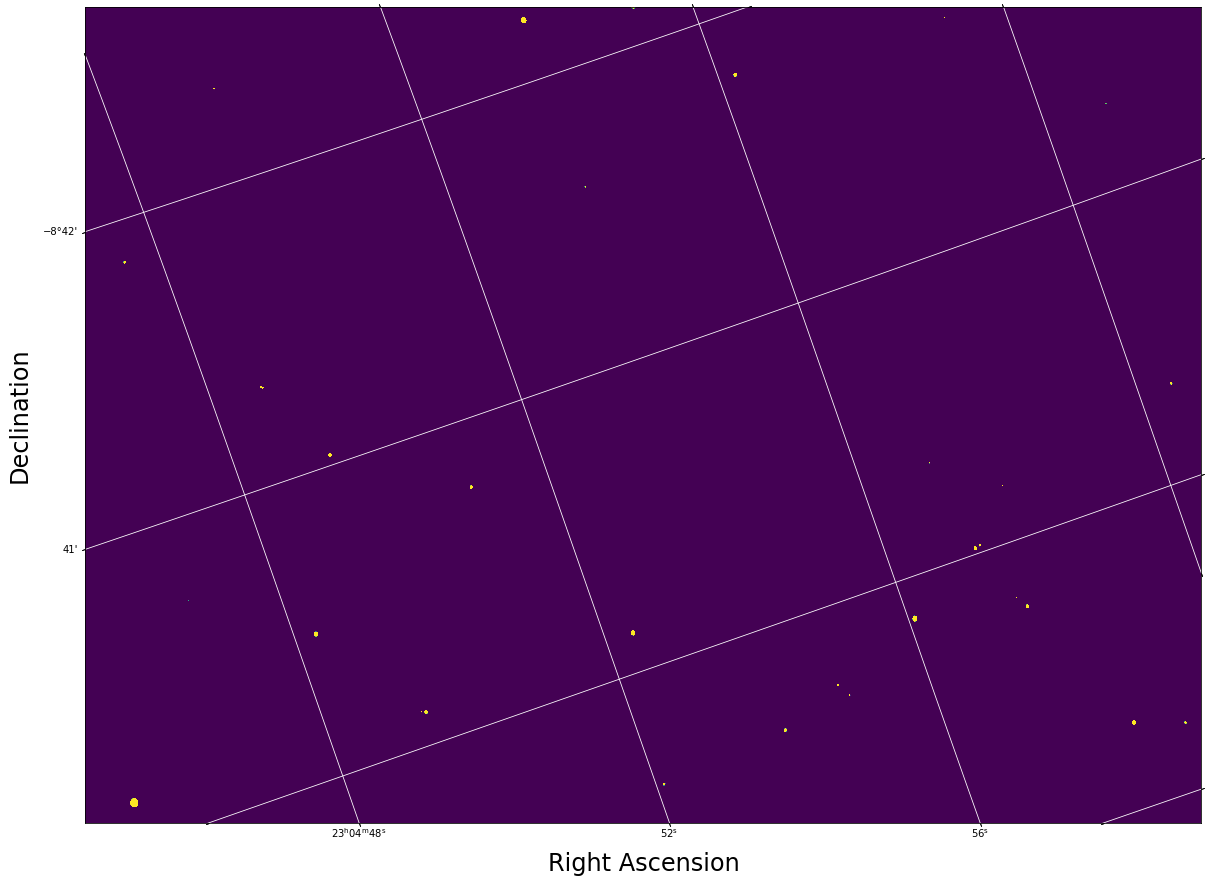

In [83]:
# define the image, open, and read the header information - use your reduced image from the previous workbook
#file = 'save.fits'
#hdu = fits.open(file)[0]
#image = hdu.data
#hdr = hdu.header

# Create the plotting object with the WCS projection.
plt.figure(figsize = (20,20))
plt.subplot(projection=wcs)
plt.imshow(image, vmin=1140, vmax=1220)
plt.grid(color='white', ls='solid', alpha=1)
plt.xlabel('Right Ascension',fontsize=24)
plt.ylabel('Declination',fontsize=24)

In [108]:
# print out the coordinates of the stars that were used for the coordinate solution
# print out the coordinates of the stars that were used for the coordinate solution
if solution.has_match():
    for star in solution.best_match().stars:
        print(f"{star.ra_deg}, {star.dec_deg}:")
        
if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
# pixels is a len(solution.best_match().stars) x 2 numpy array of float values    
print(pixels)

346.2336726615787, -8.66433147357102:
346.18823480952403, -8.669056177399309:
346.243513265095, -8.65474112509978:
346.23425808030146, -8.69655549376907:
346.2123013150077, -8.679577461529542:
346.20119195980266, -8.674652824543134:
346.23997872258013, -8.662921007300673:
346.2382475076029, -8.666945959064282:
346.2056692768748, -8.668461831367345:
346.22407622412464, -8.693401828060251:
346.21709250099656, -8.660225315520053:
346.22830047538, -8.662268106409043:
346.20532448308535, -8.683843772781202:
[[1523.05010611  372.8196899 ]
 [  89.00924428   34.45002991]
 [1925.74274443  182.41135323]
 [1193.03246209 1371.06993047]
 [ 708.11271594  614.64372349]
 [ 422.49883847  344.95976148]
 [1729.84983667  396.67316319]
 [1634.00872852  502.1196666 ]
 [ 625.47540272  201.21807829]
 [ 917.1326539  1165.83956138]
 [1062.04365155   69.90322819]
 [1381.70702764  252.12113786]
 [ 448.9027511   673.2071787 ]]


You have a choice here. You can just use the Legacy Viewer and the coordinates of these stars to get the SDSS magnitudes (use r band, but also keep the g band as we will want to look at the dependence of the calibration vs. color) to build up your photometric calibration or you can use astroquery (https://iopscience.iop.org/article/10.3847/1538-3881/aafc33) to get the magnitudes from the SIMBAD database. The latter will likely require much more effort, but will be more general if you want to make it so.

[-19.76231059]
The Zero-Point is -19.762310585161483 for this correction. The data data points seem to have a linear trend, which is what we expected


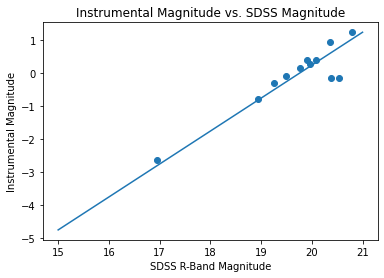

In [109]:
import scipy
from scipy.optimize import curve_fit

# values found through Legacy Viewer using RA and Dec coordinates given above
SDSS_mag_r = [18.94, 16.95, 19.50, 19.77, 19.91, 19.26, 19.97, 20.38, 20.53, 20.79, 20.08, 20.35]#, 19.46]
SDSS_mag_g = [20.20, 17.65, 20.22, 20.55, 20.19, 20.30, 20.46, 21.76, 21.65, 21.45, 21.25, 20.80]#, 20.25]

# used aperture sum 5 for teh magnitude corresponding to an aperture of 15 which is smaller than what I had used in Workbook 6

# all of the indexes closest to the pixel values found above
fluxes = []
fluxes.append(catalog['aperture_sum_5'][11])#9
fluxes.append(catalog['aperture_sum_5'][0])#0
fluxes.append(catalog['aperture_sum_5'][3])#22
fluxes.append(catalog['aperture_sum_5'][31])#13
fluxes.append(catalog['aperture_sum_5'][17])#7
fluxes.append(catalog['aperture_sum_5'][9])#10
fluxes.append(catalog['aperture_sum_5'][12])#12
fluxes.append(catalog['aperture_sum_5'][15])#4
fluxes.append(catalog['aperture_sum_5'][5])#18
fluxes.append(catalog['aperture_sum_5'][26])#1
fluxes.append(catalog['aperture_sum_5'][1])#6
fluxes.append(catalog['aperture_sum_5'][8])#15
#fluxes.append(catalog['aperture_sum_5'][3])

# find a magnitude from the flux(using 1e5 as reference flux)
inst_mag = []
for k in range(len(fluxes)):
    inst_mag.append(-2.5 * np.log10(fluxes[k]/(1e5)))

plt.scatter(SDSS_mag_r, inst_mag)
plt.xlabel('SDSS R-Band Magnitude')
plt.ylabel('Instrumental Magnitude')
plt.title('Instrumental Magnitude vs. SDSS Magnitude')

def f(x, b):
    return x + b

p0 = 0 
popt, pcov = curve_fit(f, SDSS_mag_r, inst_mag, p0)
print(popt)
x = np.arange(15, 22)
plt.plot(x, f(x, popt[0]))

print(f'The Zero-Point is {popt[0]} for this correction. The data data points seem to have a linear trend, which is what we expected')

<div class="alert alert-info"> Make a plot of instrumental magnitude vs. SDSS magnitude for these stars. Perform a linear fit to get the zero point (the offset) and check for linearity. </div>

<div class="alert alert-block alert-success">
Answer:
While the plot shows a clear linear trend between the instrumental magnitudes and SDSS R-band magnitudes, a few data points do deviate slightly from the fitted line. These outliers could be attributed to stars whose apertures overlapped with other nearby stars, leading to inaccurate flux measurements. Additionally, there were some bright stars close to the targets used for the analysis, which may have also contributed to the discrepancies in the flux values for those particular stars. Despite these few outliers, the overall trend remains consistent, supporting the validity of the linear relationship.
</div>

<div class="alert alert-info"> Now plot the offset from the fit for each star vs. color. Do you see a trend or just scatter. If there is a trend, describe the possible origin and how to address it in the calibration.</div>

The slope of the fitted line for these values is -0.7142887076232177.


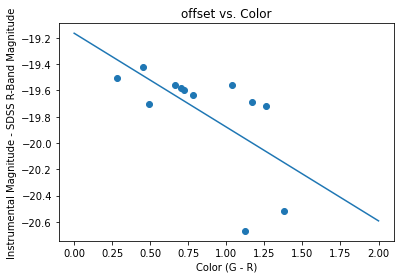

In [112]:
color = np.array(SDSS_mag_g) - np.array(SDSS_mag_r)
fit = np.array(inst_mag) - np.array(SDSS_mag_r)

plt.scatter(color, fit)
plt.xlabel('Color (G - R)')
plt.ylabel('Instrumental Magnitude - SDSS R-Band Magnitude')
plt.title('offset vs. Color')

def f2(x, a, b):
    return (a * x) - b

p0 = 0, 0
popt2, pcov2 = curve_fit(f2, color, fit, p0)

x = np.arange(0, 3)
plt.plot(x, f2(x, popt2[0], popt2[1]))
print(f'The slope of the fitted line for these values is {popt2[0]}.')

<div class="alert alert-block alert-success">
Answer:
The points while all in a general area around (-19.4) - (-19.8), there are a couple of outliers that give a clear downward trend in the plot sggesting that stars with different colors may exhibit systematic differences in the magnitude offset. This may indicate that the calibration might be color-dependent. Most of the points are spread out though. This downward trend could be caused by the differences in the filter shapes used to measure the flux for the R-Band and G-Band of the spectrum. To correct the calibration, I would find the slope of this line and add it to my final calibrated magnitude for each of my data points in the set used. Also, to improve calibration, it may be useful to apply a correction for the color dependence, adjusting the offset for redder or bluer stars to ensure the instrumental magnitudes match the SDSS magnitudes more consistently across the color spectrum.
</div>

## Conclusion: 

 <div class="alert alert-info">Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L </div>